In [87]:
import pandas as pd
import geopandas as gpd
import numpy as np
import urllib.parse
import re
from geodatasets import get_path
import matplotlib.pyplot as plt
import datetime

In [88]:
type(np.nan)

float

In [89]:
#url = u"https://vi.wikipedia.org/wiki/Danh_sách_nhà_máy_điện_Mặt_Trời_ở_Việt_Nam"
#ascii_url = urllib.parse.quote(url, safe=':/')
#tables = pd.read_html(ascii_url, encoding='utf-8')
#tables[0].to_csv('./raw/wiki_list.csv', compression=None)

In [90]:
df = pd.read_csv("./raw/wiki_list.csv", index_col=0)
df = df.drop(0)
df.columns = ['name', 'mw', 'production_mkwh_year', 'cons_start', 'op_start', 'coords', 'adm_loc', 'region_loc']
def fix_coords(c_str):
    try:
        t_str = c_str.split(sep="/")[1].replace(" \ufeff", "").split(sep=" ")
        t_str = [float(re.sub(r"°[A-Za-zĐ]", "", t).replace(",", ".")) for t in t_str]
        return t_str
    except AttributeError:
        return [np.nan, np.nan]

df['lat'] = df['coords'].apply(lambda x: fix_coords(x)[1])
df['lon'] = df['coords'].apply(lambda x: fix_coords(x)[0])
df['region_loc'] = df['region_loc'].apply(lambda x: re.sub(r" \[\d+\]", "", x))
df['adm_loc'] = df['adm_loc'].apply(lambda x: x[x.find("huyện ")+len("huyện "):] if isinstance(x, str) else np.nan)
def clean_time(date_str):
    if isinstance(date_str, float):
        return None
    formats = ["%Y", "%m/%Y"]
    date_str = str(date_str)
    for fmt in formats:
        try:
            dt = datetime.datetime.strptime(date_str, fmt)
            return int(dt.timestamp())
        except ValueError:
            continue
    raise ValueError(f"Date format for '{date_str}' not recognized.")

df['cons_start'] = df['cons_start'].apply(clean_time).astype(int)
df['op_start'] = df['op_start'].apply(clean_time).astype(int)
df = df.drop(columns='coords', axis=1)
df = df.dropna(subset=['lon'])
df['efficiency'] = df['mw']*1000/df['production_mkwh_year']
df = df.sort_values(by="efficiency", ascending=False)
df.head(20)

,name,mw,production_mkwh_year,cons_start,op_start,adm_loc,region_loc,lat,lon,efficiency
112,Dầu Tiếng 3,150.0,110.0,1.546276e+09,1.604164e+09,Tân Châu,Tây Ninh,106.201680,11.477920,1363.636364
8,Phong Điền 2,50.0,68.0,1.572541e+09,1.606756e+09,Phong Điền,Thừa Thiên Huế,107.399720,16.611820,735.294118
135,Văn Giáo 1,50.0,69.0,1.533056e+09,1.559322e+09,Tịnh Biên,An Giang,105.013140,10.469950,724.637681
136,Văn Giáo 2,50.0,69.0,1.533056e+09,1.559322e+09,Tịnh Biên,An Giang,105.013140,10.469950,724.637681
134,Sao Mai Solar PV1,210.0,302.0,1.527786e+09,1.561914e+09,Tịnh Biên,An Giang,105.010420,10.476120,695.364238
27,BMT Đắk Lắk,30.0,44.0,1.533056e+09,1.554052e+09,Krông Pắc,Đăk Lăk,108.368620,12.778470,681.818182
82,Đa Mi,47.5,70.0,1.506791e+09,1.559322e+09,Hàm Thuận Bắc,Bình Thuận,107.845570,11.253920,678.571429
118,BCG Băng Dương,40.6,60.0,1.530378e+09,1.559322e+09,Thạnh Hóa,Long An,106.170610,10.615400,676.666667
55,Hacom Solar,50.0,75.0,1.554052e+09,1.569863e+09,Thuận Nam,Ninh Thuận,108.854346,11.404554,666.666667
12,Cát Hiệp,49.5,75.0,1.519837e+09,1.556644e+09,Phù Cát,Bình Định,109.016380,14.019130,660.000000


In [91]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df['lat'], df['lon']), crs="EPSG:4326"
)
gdf.tail()

,name,mw,production_mkwh_year,cons_start,op_start,adm_loc,region_loc,lat,lon,efficiency,geometry
130,Hồ Gia Hoét 1,35.0,NaN,1.572541e+09,1.596215e+09,Châu Đức,Bà Rịa Vũng Tàu,107.28892,10.70183,NaN,POINT (107.28892 10.70183)
131,Hồ Tầm Bó,35.0,NaN,1.572541e+09,1.596215e+09,Châu Đức,Bà Rịa Vũng Tàu,107.26618,10.69919,NaN,POINT (107.26618 10.69919)
132,KCN Châu Đức,70.0,NaN,1.530378e+09,1.546276e+09,Châu Đức,Bà Rịa Vũng Tàu,107.18127,10.57919,NaN,POINT (107.18127 10.57919)
133,Bình Hòa,10.0,NaN,1.519837e+09,1.559322e+09,Châu Thành,An Giang,105.34115,10.45697,NaN,POINT (105.34115 10.45697)
138,Hậu Giang,29.0,NaN,1.590944e+09,1.606756e+09,Phụng Hiệp,Hậu Giang,105.61870,9.75956,NaN,POINT (105.6187 9.75956)


In [92]:
import os
try: 
    os.remove("./geojson/solar_plants.geojson")
except OSError:
    pass
gdf.to_file("./geojson/solar_plants.geojson", compression=None, driver="geoJSON")

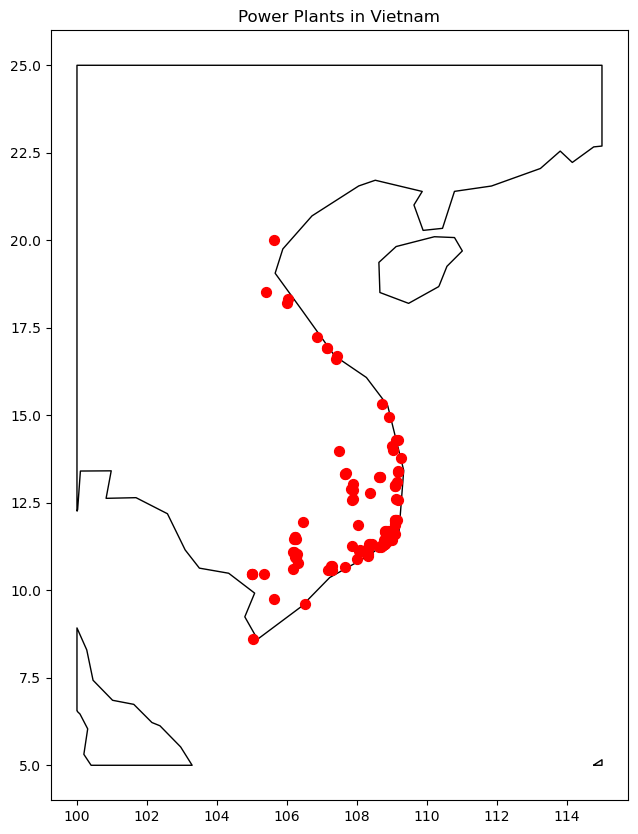

In [93]:
world = gpd.read_file(get_path("naturalearth.land"))
vietnam = world.clip([100, 5, 115, 25])
# Clip the Vietnam map to the region of interest

# Plot the map and the points
fig, ax = plt.subplots(figsize=(10, 10))
vietnam.plot(ax=ax, color='white', edgecolor='black')
gdf.plot(ax=ax, color='red', markersize=50, label="Power Plants", aspect=1)

# Add labels for the points
#for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf.name):
#    ax.text(x, y, label, fontsize=8, ha='right', va='bottom')

plt.title("Power Plants in Vietnam")
#plt.legend()
plt.show()

In [94]:
group = df.groupby(by="region_loc")
for k, v in group:
    print(k, v['mw'].sum())
#dfs = [df for _, df in group]


An Giang 320.0
Bà Rịa Vũng Tàu 188.0
Bình Phước 600.0
Bình Thuận 1168.22
Bình Định 415.5
Cà Mau 50.0
Gia Lai 113.0
Hà Tĩnh 108.0
Hậu Giang 29.0
Khánh Hòa 552.3000000000001
Kon Tum 49.0
Long An 238.6
Ninh Thuận 2715.1
Phú Yên 450.49999999999994
Quảng Bình 47.6
Quảng Ngãi 69.2
Quảng Trị 149.5
Thanh Hóa 30.0
Thừa Thiên - Huế 35.0
Thừa Thiên Huế 50.0
Trà Vinh 165.0
Tây Ninh 948.8
Đăk Lăk 1079.6
Đăk Nông 86.5
